# Assigment 3: Classical Hough Transform

## Ex. 3.1 Detect lanes and eyes

* there are two datasets available: "images/eye_tracking" and "images/lane_detection" - decide for one of them
* implement the classical Hough Transform for lines (for lane detection) OR circles (eye tracking) as shown in the lecture
* use a Canny edge detector to produce edge images for the sequence of images

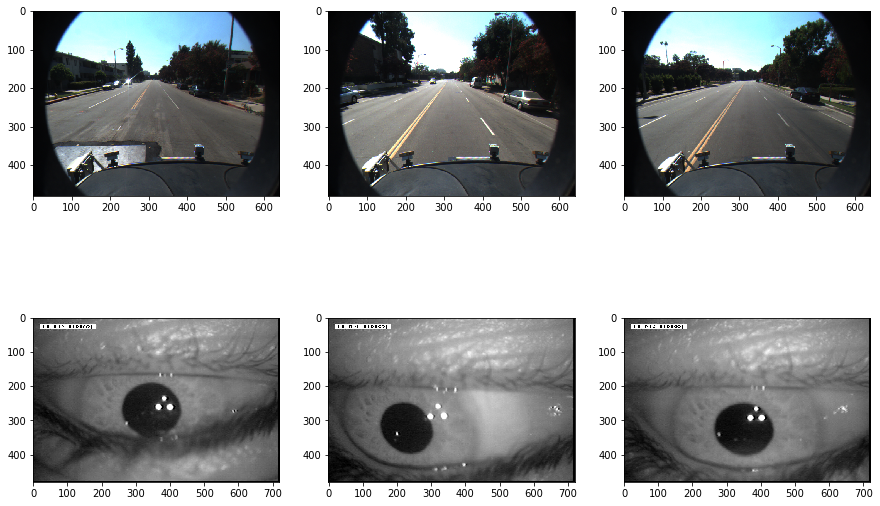

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
from skimage import io, data, feature, color
import numpy as np

lane1 = io.imread('images/lane_detection/f00000.png')
lane2 = io.imread('images/lane_detection/f00050.png')
lane3 = io.imread('images/lane_detection/f00090.png')

eye1 = io.imread('images/eye_tracking/0000.jpeg')
eye2 = io.imread('images/eye_tracking/0050.jpeg')
eye3 = io.imread('images/eye_tracking/0090.jpeg')

fig = plt.figure(figsize=(15, 10))
ax11 = plt.subplot(2, 3, 1)
ax12 = plt.subplot(2, 3, 2)
ax13 = plt.subplot(2, 3, 3)
ax21 = plt.subplot(2, 3, 4)
ax22 = plt.subplot(2, 3, 5)
ax23 = plt.subplot(2, 3, 6)



ax11.imshow(lane1)
ax12.imshow(lane2)
ax13.imshow(lane3)

ax21.imshow(eye1)
ax22.imshow(eye2)
ax23.imshow(eye3)

### Als erstes wenden wir den Canny-Edge-Detector an - Wir haben uns für das Spurendatenset entschieden

In [2]:
from skimage import img_as_float

Teste dabei verschiedene sigma Werte für die Glättung über Gauss. Canny verdünnt auch für uns die Kanten auf die Breite 1px.

In [3]:
edges1 = feature.canny(img_as_float(lane1)[:,:,0], sigma = 1.25)
edges2 = feature.canny(img_as_float(lane2)[:,:,0], sigma = 1.5) # sieht am besten aus
edges3 = feature.canny(img_as_float(lane3)[:,:,0], sigma = 1.75)

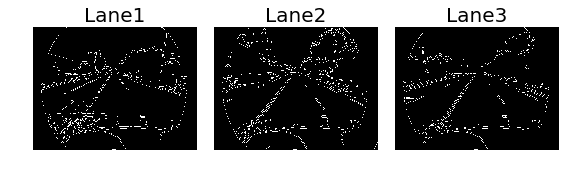

In [4]:
# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)
ax1.imshow(edges1, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('Lane1', fontsize=20)

ax2.imshow(edges2, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title('Lane2', fontsize=20)

ax3.imshow(edges3, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title('Lane3', fontsize=20)

fig.tight_layout()

plt.show()

### Nun implementiere Hough Transform, um Linien zu detektieren

In [5]:
import math

# Hilfsfunktion, wenn wir 2-er Bins für Winkel haben
# basierend auf: https://stackoverflow.com/questions/25361757/python-2-7-round-a-float-up-to-next-even-number/42667364
def round_to_next_even(f):
    number = math.ceil(f / 2.) * 2
    if number - f > 1:
        number -= 2
    return number

In [6]:
def hough_line_detector(img):
    # Von 0 bis 180 Grad in 2 Grad Schritten
    # thetas = np.deg2rad(np.arange(0.0, 180))
    
    # Wenn wir die Werte so Einschränken, dass keine Horizontalen Linien
    # akzeptiert werden, können wir die Ergebnisse stark verbessern
    intervall1 = list(np.deg2rad(np.arange(20.0, 75.0)))
    intervall2 = list(np.deg2rad(np.arange(105, 160)))
    thetas = np.array(intervall1 + intervall2)
    
    # um die verschiedenen Längen von den Vektoren zu speichern, finde den Maximalwert, 
    # den es auf dem Bild als Abstand gibt.
    # Das ist die Bilddiagonale
    diag_len = np.ceil(np.sqrt(img.shape[0]**2 +img.shape[1]**2))

    # da Vektoren in beide Richtungen gehen können, 
    # ist einmal positiv Diagonallänge drin, und einmal negativ
    # Vektorlängen v_s, 
    v_s = np.linspace(-diag_len, diag_len, diag_len * 2.0)

    # Das sind Werte, die wir wieder benutzen können
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)

    # Akkumulator mit Vektorlängen und Winkeln
    accumulator = np.zeros((2 * int(diag_len), num_thetas), dtype=np.uint64)
    
    # Extrahiere x und y Koordinaten der Kanten-Pixel
    y_idxs, x_idxs = np.nonzero(img)  # (row, col) indexes to edges
    
    # Iteriere über Pixel, die eine 1 haben.
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]

        # iteriere über die theta
        for t_idx in range(num_thetas):
            
            # Zu gegenenen Winkeln berechne die Vektorlängen
            rho = round_to_next_even(x * cos_t[t_idx] + y * sin_t[t_idx]) + diag_len
            # Inkrementieren im Akkumulator
            accumulator[int(rho), t_idx] += 1

    return accumulator, thetas, v_s

In [7]:
%matplotlib inline
from skimage import io
import numpy as np
import cv2

def draw_line_hessian_normal(image, a, r):
    
    (dimy,dimx) = image.shape 

    #r = x*cosa + y*sina

    # compute start and end point of line 
    x0 = 0
    y0 = int(round((r - x0*np.cos(a))/np.sin(a)))
    x1 = dimx-1
    y1 = int(round((r - x1*np.cos(a))/np.sin(a)))

    ret = np.copy(image)
    line = cv2.line(ret,(x0,y0),(x1,y1),(255,0,0),5)
    return line

### Wir definieren eine Funktion zum Finden der betsen Linien

In [8]:
def find_best_hough_lines(accumulator, thetas, v_s, num_lines):
    
    # indices of maximal num_lines values in accumulator
    indices = []
    for i in range(num_lines):
        index = np.unravel_index(np.argmax(accumulator, axis=None), accumulator.shape)
        accumulator[index] = 0
        indices.append(index)
    
    # Hessesche Normalform durch lookup in thetas und v_s-längen:
    lines = []
    for index in indices:
        theta = thetas[index[1]]
        v = v_s[index[0]]
        lines.append([theta, v])
    
    return lines

## line detection for lane detection 

* use your implementation of the Hough Transform to find the 10 strongest lines in the image
* display your result set (draw those lines on the image) (**RESULT**)
* can you improve the performance by limiting the space of solutions? implement and draw lines again! (**BONUS**)

In [9]:
accumulator, thetas, v_s = hough_line_detector(edges3)

C:\Users\Eduard\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


In [10]:
lines100 = find_best_hough_lines(accumulator, thetas, v_s, 100)
lines10 = find_best_hough_lines(accumulator, thetas, v_s, 10)
lines1 = find_best_hough_lines(accumulator, thetas, v_s, 1)

1.117010721276371 288.680425265791
0.5759586531581288 354.72170106316435
0.5585053606381855 362.72670419011865
2.076941809873252 -19.51219512195121
1.8675022996339325 66.54158849280793
1.2566370614359172 250.6566604127579
0.7155849933176751 360.7254534083802
1.9373154697137058 34.52157598499059
0.7504915783575618 370.7317073170732
0.7853981633974483 370.7317073170732


C:\Users\Eduard\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Users\Eduard\AppData\Local\Programs\Python\Python36\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


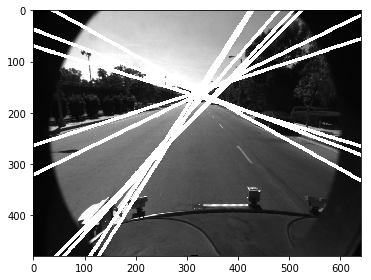

In [11]:
image = lane3[:,:,0]
for l in lines10:
    theta = l[0]
    length = l[1]
    print(theta, length)
    image = draw_line_hessian_normal(image, theta, length)
io.imshow(image)

### Nachdem die ersten 10 Linien gut treffen, gucken wir uns die weiteren an

C:\Users\Eduard\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Users\Eduard\AppData\Local\Programs\Python\Python36\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


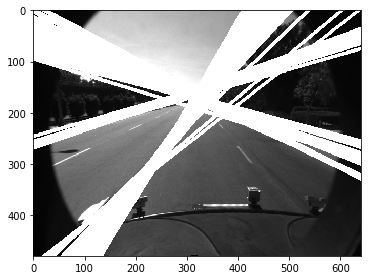

In [12]:
image = lane3[:,:,0]
for l in lines100:
    theta = l[0]
    length = l[1]
    image = draw_line_hessian_normal(image, theta, length)
io.imshow(image)

# Ex. 3.2 Generalized Hough Transform

* implement the Generalized Hough Transform as described in the lecture for localizing a given template
* find the given template (see below) and mark its location in the image "animals.png" (**RESULT**)

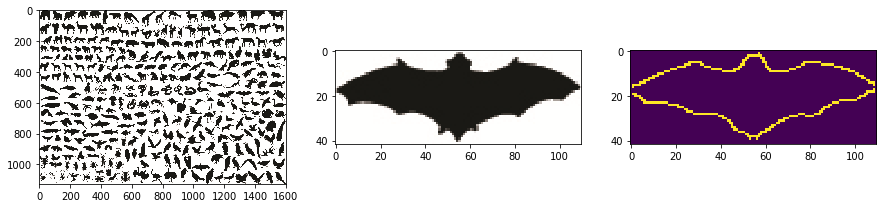

In [20]:
%matplotlib inline 
import matplotlib.pyplot as plt
from skimage import io, data, feature, color
import numpy as np

animals = io.imread('images/animals.png')

xmin = 1271
xmax = 1381
ymin = 519
ymax = 561

bat = animals[ymin:ymax, xmin:xmax]
bat_edge = feature.canny(color.rgb2gray(bat), 2)

fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(animals)
ax2.imshow(bat)
ax3.imshow(bat_edge)

In [21]:
from scipy.ndimage.filters import sobel
from collections import defaultdict

### Wir implementieren die Funktionen so wie in der Vorlesung beschrieben

In [43]:
nbins = 180


def binify(nrOfBins, rangeStart, rangeEnd, targetArray):
    '''
    Sets all values that are in one bin, as defined by range
    and nrOfBins, to the mid-value of the corresponding bin.
    '''
    stepsize = (rangeEnd - rangeStart) / nbins
    bin_start = rangeStart
    bin_end = rangeStart + stepsize/2
    lower_bound_mask = targetArray >= bin_start
    upper_bound_mask = targetArray < bin_end
    and_mask = np.logical_and(lower_bound_mask, upper_bound_mask)
    targetArray[and_mask] = bin_start
    for _ in range(1, nbins):
        # define bin borders
        bin_start = bin_end
        bin_end = bin_start + stepsize
        
        lower_bound_mask = targetArray >= bin_start
        upper_bound_mask = targetArray < bin_end
        and_mask = np.logical_and(lower_bound_mask, upper_bound_mask)
        targetArray[and_mask] = bin_start + stepsize/2
    
    return targetArray


# Hilfsfunktionen:
def gradient_orientation(edges):
    # für jedes Pixel gradient orientation rausfinden.
    dx = sobel(edges, axis=0, mode='constant')
    dy = sobel(edges, axis=1, mode='constant')
    
    # wir wollen Gradienten nicht in rad, sondern in deg
    gradient = np.arctan2(dy,dx) * 180 / np.pi
 
    # Gradient ist das array voller Winkel
    return gradient


# hatte früher image
def make_r_table(edges, center, gradient, nbins):
    # baue die r-tabelle auf, gegeben die kanten
    gradient = gradient_orientation(edges)
    
    # put the gradients in bins
    binned_gradient = binify(nbins, -180.0, 180.0, gradient)
    
    # create empty dict for r table
    r_table = defaultdict(list)
    
    # Finde Indizes, wo eine 1 steht, also Kante sein könnte
    y_idxs, x_idxs = np.nonzero(edges)  # (row, col) indexes to edges
   
    # Iteriere über Pixel, die eine 1 haben.
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]
        
        # in der r table werden eingetragen, zu jedem winkel aus gradient, der dazu passende vektor
        r_table[gradient[y,x]].append((center[0]-y, center[1]-x))

    return r_table

#hatte früher grayImage
def accumulate_gradients(r_table, edges, gradient, nbins):
    # fülle akkumulator
    
    gradient = gradient_orientation(edges)
    
    # put the gradients in bins
    binned_gradient = binify(nbins, -180.0, 180.0, gradient)
    
    # anfangs ist alles im akkumulator null
    accumulator = np.zeros(edges.shape)
    
    # Finde Indizes, wo eine 1 steht, also Kante sein könnte
    y_idxs, x_idxs = np.nonzero(edges)  # (row, col) indexes to edges
   
    # Iteriere über Pixel, die eine 1 haben.
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]
      
        # für jeden vektor in der tabelle:
        # nimm die aktuelle kantenkoordinate
        # und addiere den vektor drauf
        # achte dabei darauf, nicht aus dem bild zu fallen.
        for r in r_table[gradient[y,x]]:
            accum_y, accum_x = y+r[0], x+r[1]
            if accum_y < accumulator.shape[0] and accum_x < accumulator.shape[1]:
                accumulator[accum_y, accum_x] += 1

    return accumulator


def calcMoments(prob_distr):
    # zeroth moment
    zero_mom = np.sum(prob_distr)
    
    # first moment x
    x_weighted_prob = prob_distr * [i for i in range(1, prob_distr.shape[1]+1)] 
    f1_mom = np.sum(x_weighted_prob)
    
    # first moment y
    y_weighted_prob = prob_distr * np.array([[i] for i in range(1, prob_distr.shape[0]+1)])
    f2_mom = np.sum(y_weighted_prob)
    
    return zero_mom, f1_mom, f2_mom


def calculate_center(binary_image):
    # berechne den schwerpunkt von einem bild
    # wie in cam-shift
    
    m00, m10, m01 = calcMoments(binary_image)
    
    x_center = m10//m00
    y_center = m01//m00
    
    return (y_center, x_center)


def query_image(query_image, r_table, gradients, nbins):
    return accumulate_gradients(r_table, query_image, gradients, nbins)

In [35]:
center = calculate_center(bat_edge)

In [36]:
animals_edge = feature.canny(color.rgb2gray(animals), 2)

### Das Kantenbild aller Tiere

C:\Users\Eduard\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Users\Eduard\AppData\Local\Programs\Python\Python36\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


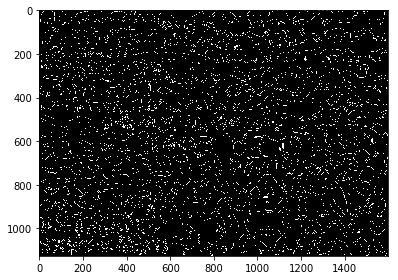

In [37]:
io.imshow(animals_edge)

In [49]:
edges = bat_edge
gradients = gradient_orientation(edges)
r_table = make_r_table(edges, center, gradients, nbins)
accu = query_image(animals_edge, r_table, gradients, nbins)

### Der Index, an dem die Fledermaus gefunden wird

In [45]:
import matplotlib.patches as patches

In [46]:
coords = np.unravel_index(np.argmax(accu, axis=None), accu.shape)
coords

(537, 1326)

In [47]:
def drawPointOnImage(image, x, y, radius=30):
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(image, cmap='binary_r')
    circle = patches.Circle((y,x),radius)
    ax.add_patch(circle)
    
    plt.show()

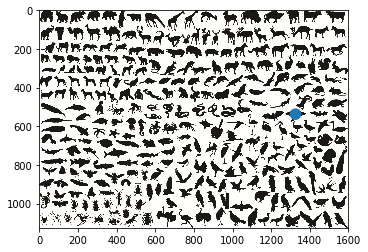

In [48]:
drawPointOnImage(animals,coords[0],coords[1])

# Wie man sieht wird die Fledermaus perfekt getroffen.